In [1]:
import pandas as pd
import pickle
import numpy as np
from brainflow.board_shim import BoardShim, BrainFlowInputParams, LogLevels, BoardIds
from brainflow.data_filter import DataFilter, FilterTypes
import matplotlib
import os
import torch
import pytorch_lightning as pl
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from pytorch_lightning.loggers import WandbLogger
from torchmetrics.classification import BinaryF1Score, BinaryAccuracy
from pytorch_lightning.callbacks import Callback
from sklearn import metrics

import cv2
from torch.utils.data import DataLoader
import wandb

matplotlib.use('Agg')
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
%matplotlib inline
scaler = StandardScaler()

In [2]:
wandb.login()
api_key = 'a45abb01f9556b57620ce77c8984452bee7a8772'
board_id = 38
eeg_names = ['TP9', 'Fp1', 'Fp2', 'TP10', 'AUX']
sf = 256

wandb: Currently logged in as: nickhartono. Use `wandb login --relogin` to force relogin


In [3]:
class PickleLatentDatasetLoader(Dataset):
    def __init__(self, annotations_file, dir):
        self.file_lists = pd.read_csv(annotations_file, header=None)
        self.dir = dir

    def __len__(self):
        return len(self.file_lists)

    def __getitem__(self, idx):
        file_path = os.path.join(self.dir, self.file_lists.iloc[idx, 0].replace('/','\\'))
        label = self.file_lists.iloc[idx, 1]

        pkl_file = open(file_path, 'rb')
        results = pickle.load(pkl_file)
        results = np.array(results)
        pkl_file.close()

        results = torch.tensor(results)
        label = torch.tensor(label).type(torch.FloatTensor)

        return (results[0], results[1], label)

In [4]:
pkl_dir = 'D:\\Nicko\\TUGAS_AKHIR\\Dataset_new_12\\Dataset_TA_pkl\\LATENT_32640_2CHANNEL\\'
path_file = pkl_dir + 'path_and_label.csv'
train_dir = pkl_dir + 'train_set.csv'
valid_dir = pkl_dir + 'valid_set.csv'
test_dir = pkl_dir + 'test_set.csv'

In [5]:
datasetsTrain = PickleLatentDatasetLoader(
    annotations_file=train_dir,
    dir=pkl_dir
)
datasetsValid = PickleLatentDatasetLoader(
    annotations_file=valid_dir,
    dir=pkl_dir
)
datasetsTest = PickleLatentDatasetLoader(
    annotations_file=test_dir,
    dir=pkl_dir
)

In [6]:
# data loader
train_dataloader = DataLoader(datasetsTrain, batch_size=50)
validation_dataloader = DataLoader(datasetsValid, batch_size=50)
test_dataloader = DataLoader(datasetsTest, batch_size=50)

In [7]:
#MODEL 2 (LSTM)
class LitClassifierwithLSTM(pl.LightningModule):
    def __init__(self, input_shape, learning_rate=1e-4):
        super().__init__()

        # log hyperparameters
        self.save_hyperparameters()
        self.learning_rate = learning_rate
        self.loss_fn = torch.nn.BCEWithLogitsLoss()
        self.hidden_state = 32
        self.num_layers = 3

        # variable
        self.predictions = np.array([])
        self.targets = np.array([])
        self.predictions_val = np.array([])
        self.targets_val = np.array([])
        self.predictions_test = np.array([])
        self.targets_test = np.array([])
        self.f1_fn = BinaryF1Score()
        self.acc_fn = BinaryAccuracy()
        self.f1_train = 0
        self.f1_val = 0
        self.f1_test = 0
        self.acc_train = 0
        self.acc_val = 0
        self.acc_test = 0

        # Flatten
        self.flatten_layer = torch.nn.Flatten(start_dim=1)

        # LSTM
        lstm_input_size = self._get_output_shape(input_shape)
        self.lstm_layer = torch.nn.LSTM(input_size=lstm_input_size, hidden_size=self.hidden_state, num_layers=self.num_layers, dropout=0.2, batch_first=True, bidirectional=True)

        # Fully Connected
        n_sizes = self.hidden_state*2
        self.fc_layer = torch.nn.Sequential(
            torch.nn.Linear(n_sizes, 32),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(32, 1)
        )

    def _get_output_shape(self, shape):
        batch_size = 50
        input = torch.autograd.Variable(torch.rand(batch_size, *shape))
        n_size = input.data.view(batch_size, -1).size(1)
        print(n_size*2)
        return n_size*2

    def forward(self, x1, x2):
         x_combined = torch.stack([x1,x2], dim=0)
         x_flat = self.flatten_layer(x_combined)
         x_lstmed = self.lstm_layer(x_flat)
         y_logits = self.fc_layer(x_lstmed)
         y_pred = torch.round(torch.sigmoid(y_logits))
         return y_pred

    def training_step(self, batch, batch_idx):
        x1, x2, y = batch
        x_combined = torch.stack([x1,x2], dim=1)
        x_flat = self.flatten_layer(x_combined)
        x_lstmed,_ = self.lstm_layer(x_flat)
        y_logits = self.fc_layer(x_lstmed)
        y_logits = y_logits.squeeze()
        loss = self.loss_fn(y_logits, y)
        acc = self.acc_fn(y_logits, y)
        self.log("train_loss", loss)
        self.log("train_acc", acc)
        y_preds = torch.round(torch.sigmoid(y_logits.cpu())).detach().numpy()
        self.predictions = np.append(self.predictions, y_preds, axis=0)
        self.targets = np.append(self.targets, y.cpu(), axis=0)
        return {"loss": loss, "acc": acc}

    def validation_step(self, val_batch, batch_idx):
        x1, x2, y = val_batch
        x_combined = torch.stack([x1,x2], dim=1)
        x_flat = self.flatten_layer(x_combined)
        x_lstmed,_ = self.lstm_layer(x_flat)
        y_logits = self.fc_layer(x_lstmed)
        y_logits = y_logits.squeeze()
        val_loss = self.loss_fn(y_logits, y)
        val_acc = self.acc_fn(y_logits, y)
        self.log("val_loss", val_loss)
        self.log("val_acc", val_acc)
        y_preds = torch.round(torch.sigmoid(y_logits.cpu())).detach().numpy()
        self.predictions_val = np.append(self.predictions_val, y_preds, axis=0)
        self.targets_val = np.append(self.targets_val, y.cpu(), axis=0)
        return {"val_loss": val_loss, "val_acc": val_acc}

    def test_step(self, test_batch, batch_idx):
        x1, x2, y = test_batch
        x_combined = torch.stack([x1,x2], dim=1)
        x_flat = self.flatten_layer(x_combined)
        x_lstmed,_ = self.lstm_layer(x_flat)
        y_logits = self.fc_layer(x_lstmed)
        y_logits = y_logits.squeeze()
        test_loss = self.loss_fn(y_logits, y)
        test_acc = self.acc_fn(y_logits, y)
        self.log("test_loss", test_loss)
        self.log("test_acc", test_acc)
        y_preds = torch.round(torch.sigmoid(y_logits.cpu())).detach().numpy()
        conf_matrix = metrics.confusion_matrix(y.cpu(), y_preds)
        conf_matrix = np.flip(conf_matrix).T
        legend = ['Lie','Truth']
        legend2 = [['(TP)','(FP)'],['(FN)','(TN)']]
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
        ax.set_xticklabels([''] + legend)
        ax.set_yticklabels([''] + legend)
        for i in range(conf_matrix.shape[0]):
            for j in range(conf_matrix.shape[1]):
                ax.text(x=j, y=i, s=(str(conf_matrix[i, j]) + ' ' + legend2[i][j]), va='center', ha='center', size='xx-large')

        plt.ylabel('Predictions', fontsize=20)
        plt.title('Actual', fontsize=20)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.tight_layout(pad=1)
        y_preds = torch.round(torch.sigmoid(y_logits))
        f1score = self.f1_fn(y_preds, y)
        print('F1-score:', f1score)
        plt.show()
        return {"test_loss": test_loss, "test_acc": test_acc}

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        return optimizer

In [ ]:
classifierLSTM = LitClassifierwithLSTM(input_shape=(64,10,51))

In [ ]:
class LoggingCallback(Callback):
    def __init__(self):
        super().__init__()
        self.f1 = BinaryF1Score()

    def on_train_epoch_start(self, trainer: "pl.Trainer", pl_module: "pl.LightningModule") -> None:
        pl_module.predictions = np.array([])
        pl_module.targets = np.array([])

    def on_train_epoch_end(self, trainer: "pl.Trainer", pl_module: "pl.LightningModule") -> None:
        pl_module.f1_train = pl_module.f1_fn(torch.tensor(pl_module.predictions.squeeze()), torch.tensor(pl_module.targets.squeeze()))
        pl_module.log('F1_Score', pl_module.f1_train)

    def on_validation_epoch_start(self, trainer: "pl.Trainer", pl_module: "pl.LightningModule") -> None:
        pl_module.predictions_val = np.array([])
        pl_module.targets_val = np.array([])

    def on_validation_epoch_end(self, trainer: "pl.Trainer", pl_module: "pl.LightningModule") -> None:
        pl_module.f1_val = pl_module.f1_fn(torch.tensor(pl_module.predictions_val.squeeze()), torch.tensor(pl_module.targets_val.squeeze()))
        pl_module.log('F1_Score_val', pl_module.f1_val)

In [ ]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor="F1_Score_val",
    mode="max",
    dirpath="E:\\Nicko\\TUGAS_AKHIR\\ClasifierLSTMFc\\runs\\run_1",
    filename="classifier-{epoch:02d}-{F1_Score_val:.2f}",
    save_top_k=5,
    save_last=True
)
logging_callback = LoggingCallback()

In [ ]:
wandb_logger = WandbLogger(project='classifier_lstm_fc', name='run_1', save_dir='E:\\Nicko\\TUGAS_AKHIR\\ClasifierLSTMFc\\runs')

In [ ]:
trainer = pl.Trainer(max_epochs=5000, devices=1, accelerator='gpu', log_every_n_steps=3, logger=wandb_logger, callbacks=[checkpoint_callback, logging_callback])
trainer.fit(classifierLSTM, train_dataloader, validation_dataloader)
wandb.finish()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


65280
65280


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
D:\Nicko\TUGAS_AKHIR\TA_env\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

F1-score: tensor(0., device='cuda:0')


C:\Users\Nicko\AppData\Local\Temp\ipykernel_16244\1488790590.py:109: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + legend)
C:\Users\Nicko\AppData\Local\Temp\ipykernel_16244\1488790590.py:110: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + legend)


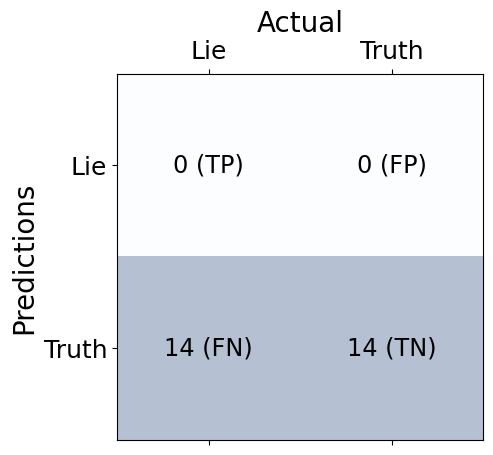

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                    0.5
        test_loss           0.6972235441207886
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.6972235441207886, 'test_acc': 0.5}]

In [8]:
trainer = pl.Trainer(max_epochs=5000, devices=1, accelerator='gpu', log_every_n_steps=3, logger=False)
classifier_load = LitClassifierwithLSTM(input_shape=(64, 10, 51)).load_from_checkpoint(
    checkpoint_path='E:\\Nicko\\TUGAS_AKHIR\\ClasifierLSTMFc\\runs\\run_1\\last.ckpt')
trainer.test(classifier_load, test_dataloader)